# Masinsko ucenje, Elektronski fakultet 2021

## Projekat 2

### Aleksandar Gavric, Nikola Blagojevic


In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

# Import the Movies dataset
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
# Import the ratings dataset
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
# Print the number of records and the total number of movies
print('Dataset sadrzi: ', len(ratings), ' ocena za ', len(movies), ' filmova.')

Dataset sadrzi:  100836  ocena za  9742  filmova.


In [4]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
gr1 = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings = gr1
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [30]:
# Function to get the genre ratings
def get_genre_ratings1(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']]
        avg_genre_votes_per_user = genre_votes_per_user.groupby(['userId'])['rating'].mean().round(2)
        cnt_genre_votes_per_user = genre_votes_per_user.groupby(['userId'])['rating'].count()
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user, cnt_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings1 = get_genre_ratings1(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'cnt_romance_rating','avg_scifi_rating', 'cnt_scifi_rating'])
genre_ratings1.head()

,avg_romance_rating,cnt_romance_rating,avg_scifi_rating,cnt_scifi_rating
1,4.31,26.0,4.22,40.0
2,4.50,1.0,3.88,4.0
3,0.50,5.0,4.20,15.0
4,3.38,58.0,2.83,12.0
5,3.09,11.0,2.50,2.0


In [34]:
cnts = genre_ratings1.iloc[:, [x for x in range(len(genre_ratings1.columns)) if x % 2 == 1]]
cnts

,cnt_romance_rating,cnt_scifi_rating
1,26.0,40.0
2,1.0,4.0
3,5.0,15.0
4,58.0,12.0
5,11.0,2.0
...,...,...
606,355.0,79.0
607,29.0,36.0
608,106.0,167.0
609,5.0,5.0


In [36]:
genre_ratings_sums = cnts.sum(axis=1)
genre_ratings_sums

1       66.0
2        5.0
3       20.0
4       70.0
5       13.0
       ...  
606    434.0
607     65.0
608    273.0
609     10.0
610    370.0
Length: 610, dtype: float64

In [58]:
procs_cnt = (cnts.T / genre_ratings_sums.T).T
genre_ratings_ratings = genre_ratings1.iloc[:, [x for x in range(len(genre_ratings1.columns)) if x % 2 == 0]] 
gr2 = genre_ratings_ratings * procs_cnt.values

In [68]:
genre_ratings = gr1

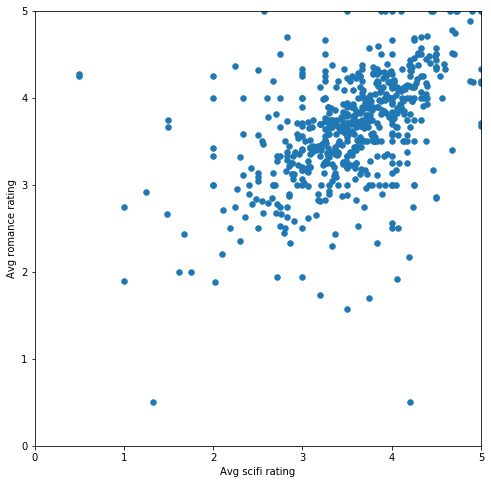

In [69]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(genre_ratings['avg_scifi_rating'],'Avg scifi rating', genre_ratings['avg_romance_rating'], 'Avg romance rating')

In [70]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


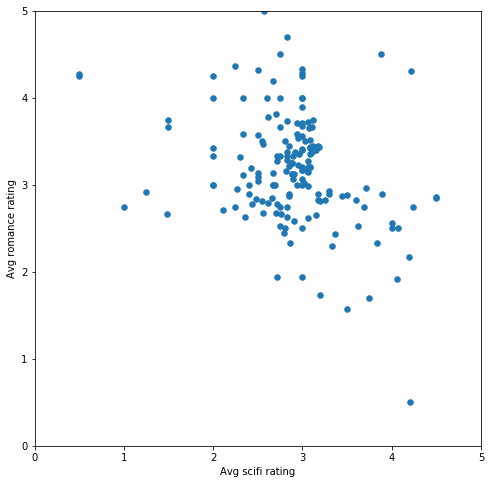

In [71]:
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

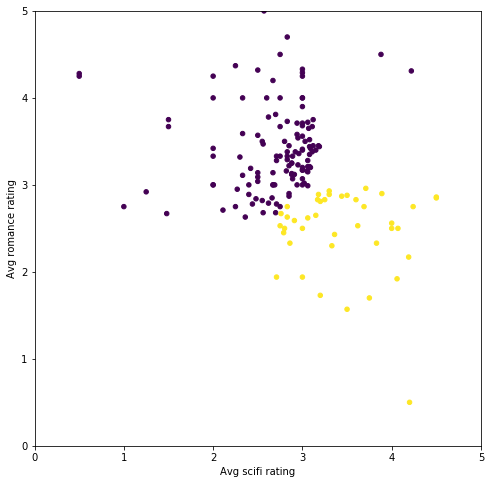

In [72]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

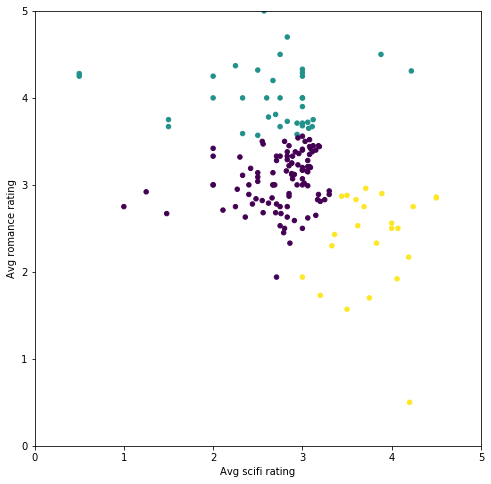

In [73]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)


C:\Users\aleks\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return_n_iter=True)


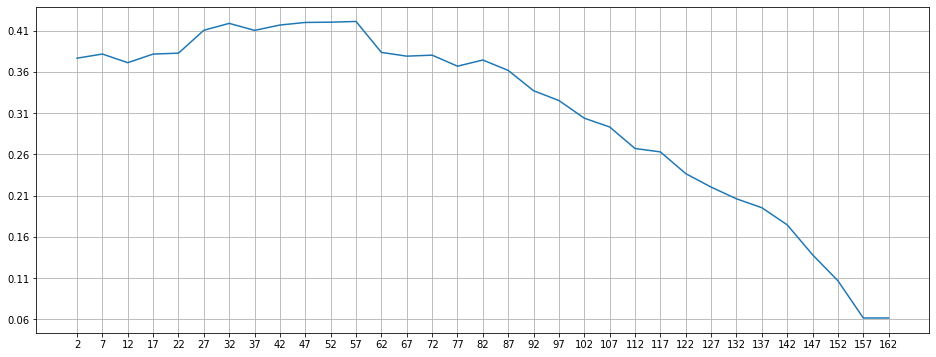

In [74]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Najbolje za K: 7, 32, 36, 47. Biramo K = 7 (da bi mogli i da vizualizujemo laske). Koristimo Silhouette Score.

The range of Silhouette score is [-1, 1]. 

Its analysis is as follows −
+1 Score − Near +1 Silhouette score indicates that the sample is far away from its neighboring cluster.
0 Score − 0 Silhouette score indicates that the sample is on or very close to the decision boundary separating two neighboring clusters.


-1 Score − 1 Silhouette score indicates that the samples have been assigned to the wrong clusters.
The calculation of Silhouette score can be done by using the following formula
silhouettescore=(p−q)/max(p,q)
silhouettescore=(p−q)/max(p,q)
Here, p = mean distance to the points in the nearest cluster
And, q = mean intra-cluster distance to all the points.

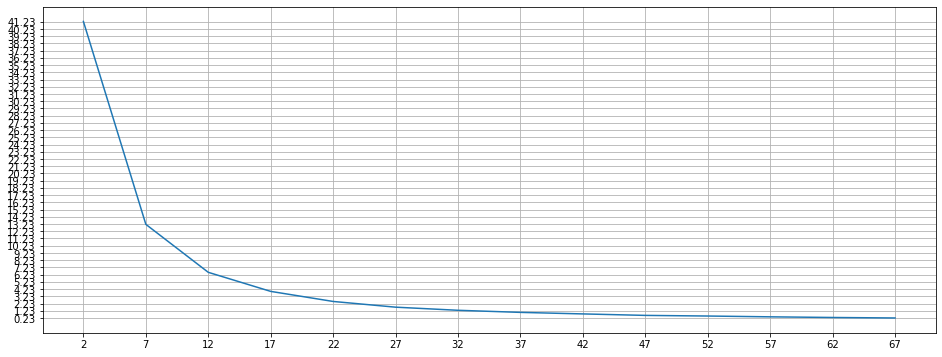

In [81]:
def clustering_errorsMSE(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)

possible_k_values = range(2, 72, 5)
# Calculate error values for all k values we're interested in
errors1_per_k = [clustering_errorsMSE(k, X) for k in possible_k_values]
# Plot the each value of K vs. the MSE at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors1_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors1_per_k), 2), max(errors1_per_k))
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

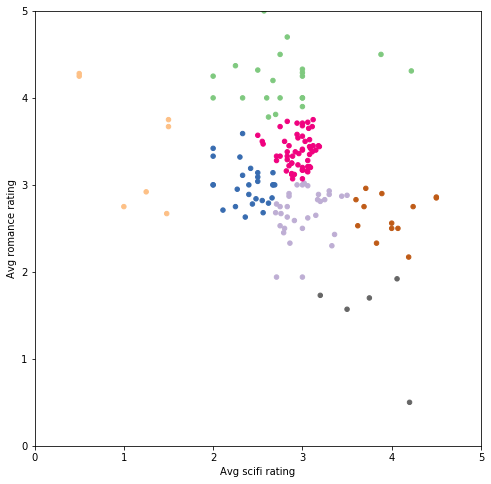

In [82]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

### Nakon tranformacije podataka

In [75]:
genre_ratings = gr2

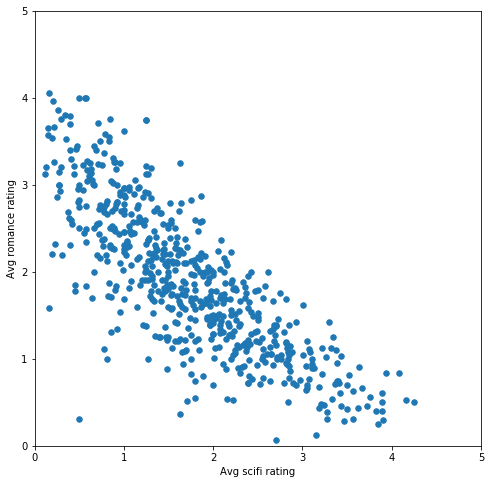

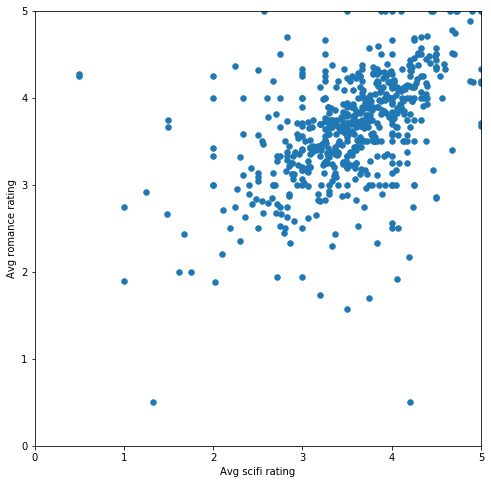

In [77]:
draw_scatterplot(gr1['avg_scifi_rating'],'Avg scifi rating', gr1['avg_romance_rating'], 'Avg romance rating')
draw_scatterplot(gr2['avg_scifi_rating'],'Avg scifi rating', gr2['avg_romance_rating'], 'Avg romance rating')

Number of records:  263


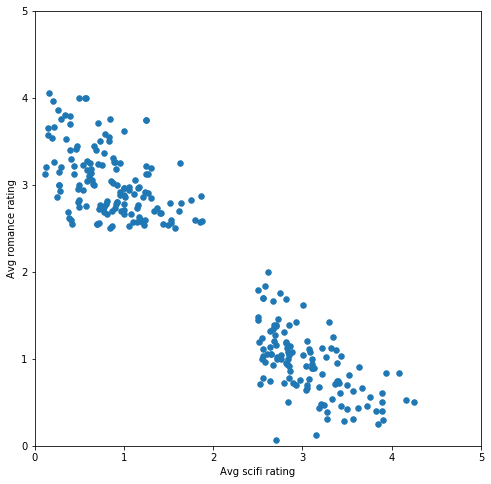

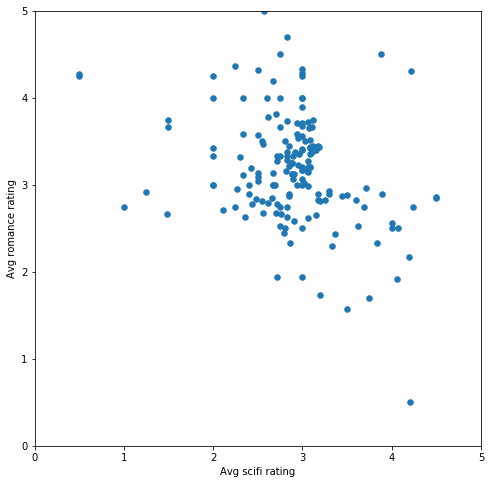

In [79]:
# Bias the dataset
biased_dataset1 = bias_genre_rating_dataset(gr1, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset1))
biased_dataset1.head()
draw_scatterplot(biased_dataset1['avg_scifi_rating'],'Avg scifi rating', biased_dataset1['avg_romance_rating'], 'Avg romance rating')
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

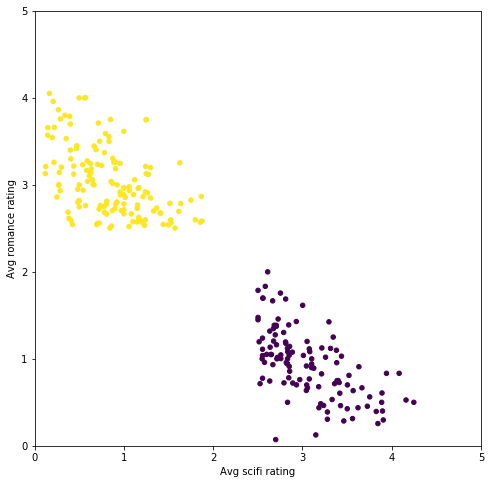

In [80]:
# Let's turn our dataset into a list
X1 = biased_dataset1[['avg_scifi_rating','avg_romance_rating']].values

# Create an instance of KMeans to find two clusters
kmeans_1a = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions1 = kmeans_1a.fit_predict(X1)
# Plot
draw_clusters(biased_dataset1, predictions1)

In [83]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[100:106, 100:110]

dataset dimensions:  (610, 9719) 

Subset example:


title,3 dev adam (Three Giant Men) (1973),3-Iron (Bin-jip) (2004),30 Days of Night (2007),30 Minutes or Less (2011),300 (2007),3000 Miles to Graceland (2001),300: Rise of an Empire (2014),31 (2016),35 Up (1991),"39 Steps, The (1935)"
userId,,,,,,,,,,
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

# Define the sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

# choose the number of movies and users and sort
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
# Print the result

most_rated_movies_users_selection.iloc[0:5, 0:10]

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993)
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0


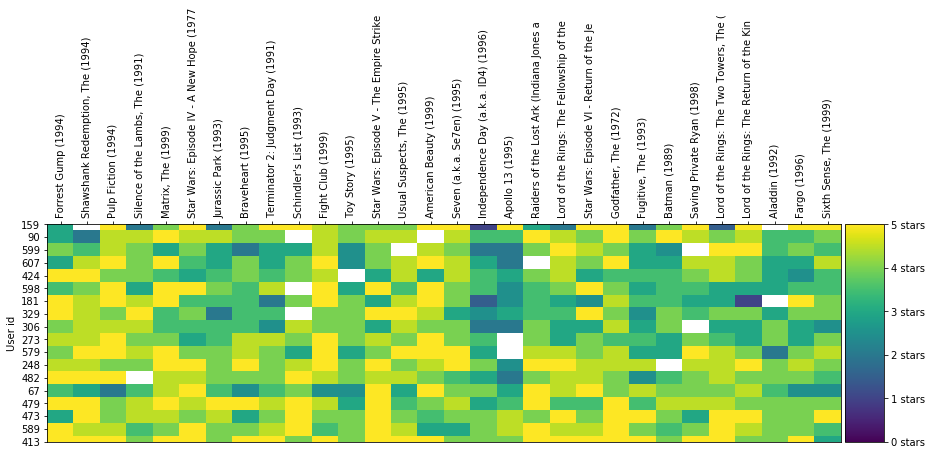

In [96]:
# Define the plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
plt.show()
# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

Tumacenje heat mape:
- Svaka kolona je drugačiji film.
- Svaki red je drugačiji korisnik.
- Boja ćelije je ocena koju je svaki korisnik dodelio svakom filmu. Vrednosti za svaku boju mogu se proveriti na skali desno.
- Vrednosti bele boje odgovaraju korisnicima koji nisu ocenili film.

In [97]:
# Pivot the dataset and choose the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [98]:
# Conversion to sparse csr matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

C:\Users\aleks\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  
C:\Users\aleks\Anaconda3\lib\site-packages\pandas\core\frame.py:3456: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


cluster # 4
# of users in cluster: 31. # of users in plot: 31


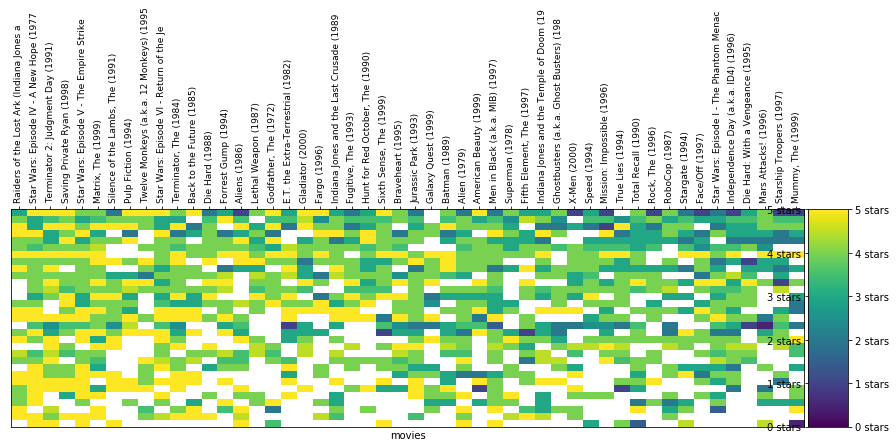

cluster # 18
# of users in cluster: 231. # of users in plot: 70


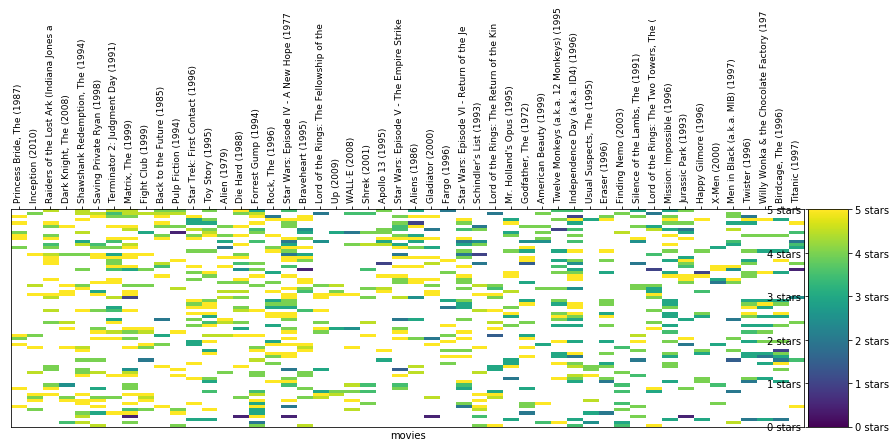

cluster # 12
# of users in cluster: 21. # of users in plot: 21


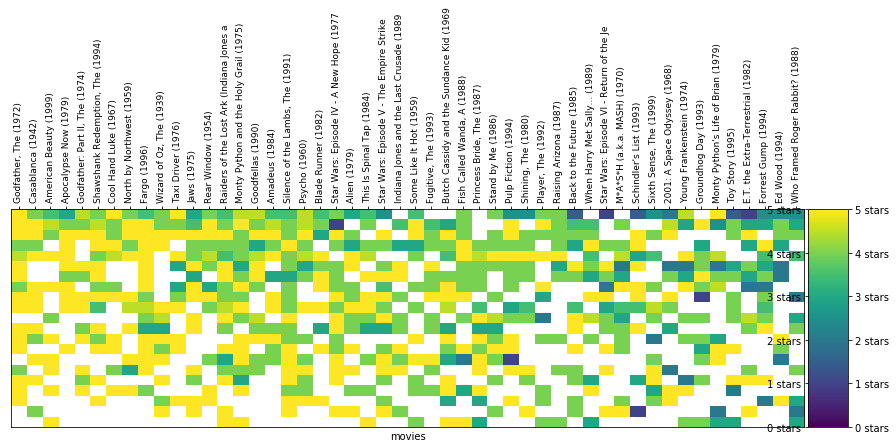

cluster # 0
# of users in cluster: 88. # of users in plot: 70


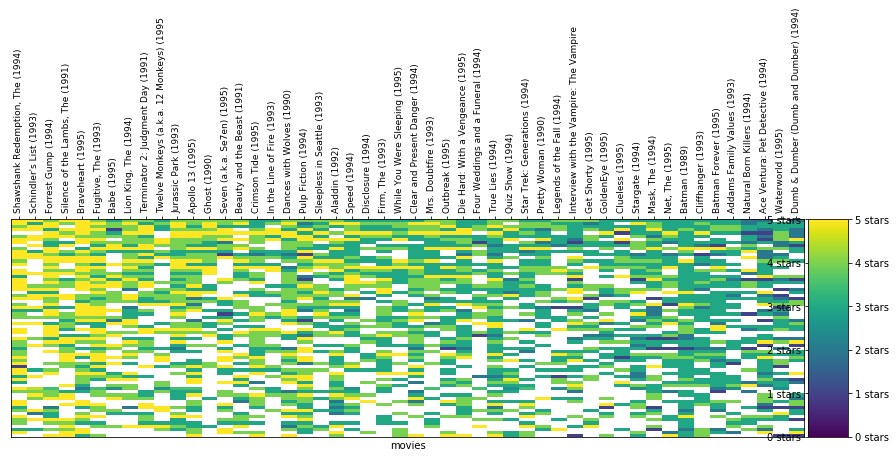

cluster # 14
# of users in cluster: 73. # of users in plot: 70


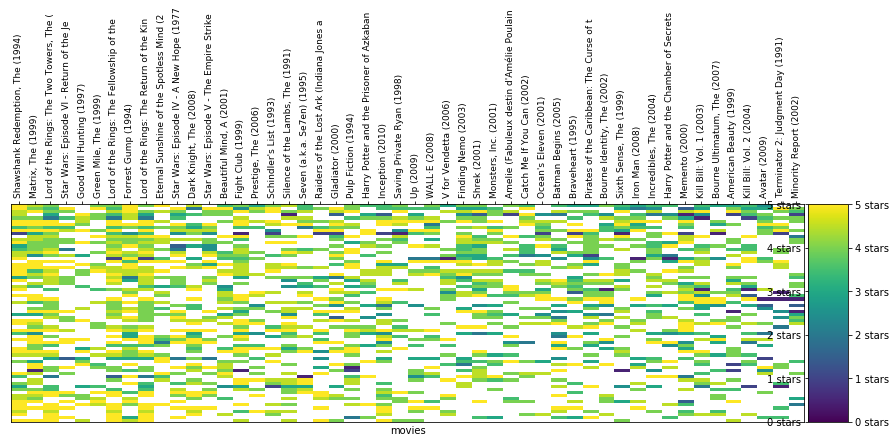

cluster # 17
# of users in cluster: 70. # of users in plot: 70


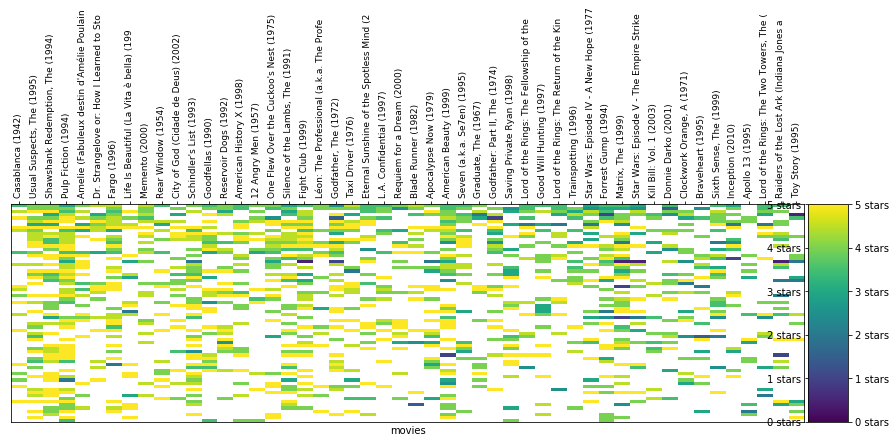

cluster # 10
# of users in cluster: 34. # of users in plot: 34


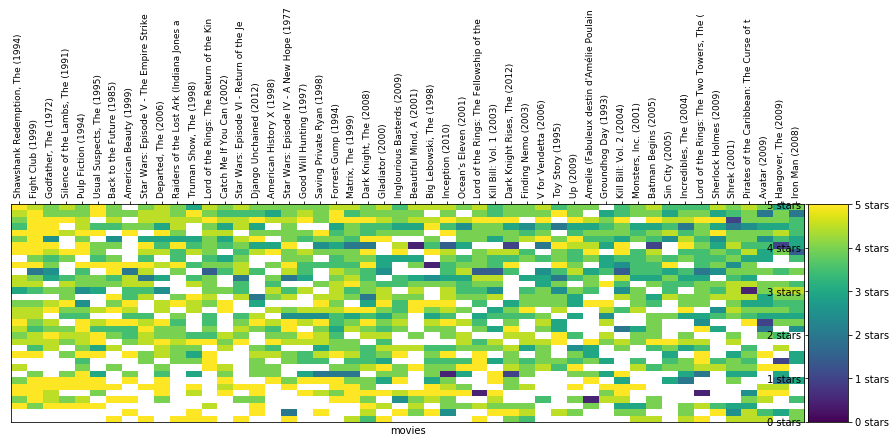

cluster # 19
# of users in cluster: 17. # of users in plot: 17


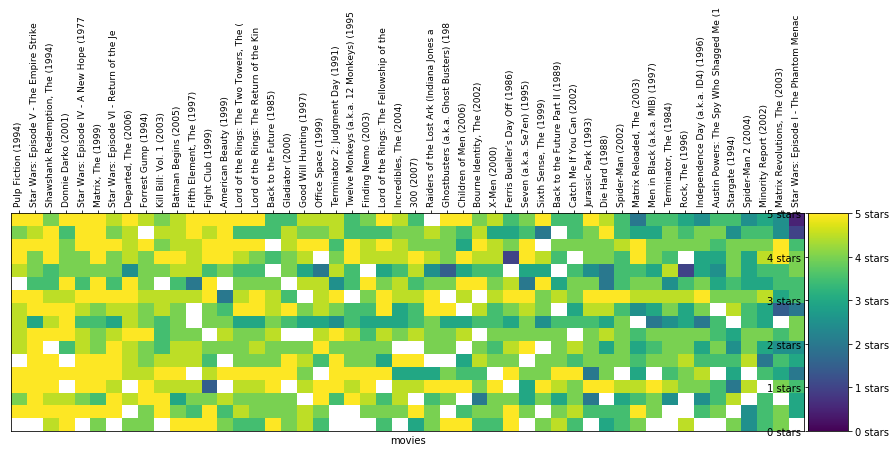

cluster # 16
# of users in cluster: 12. # of users in plot: 12


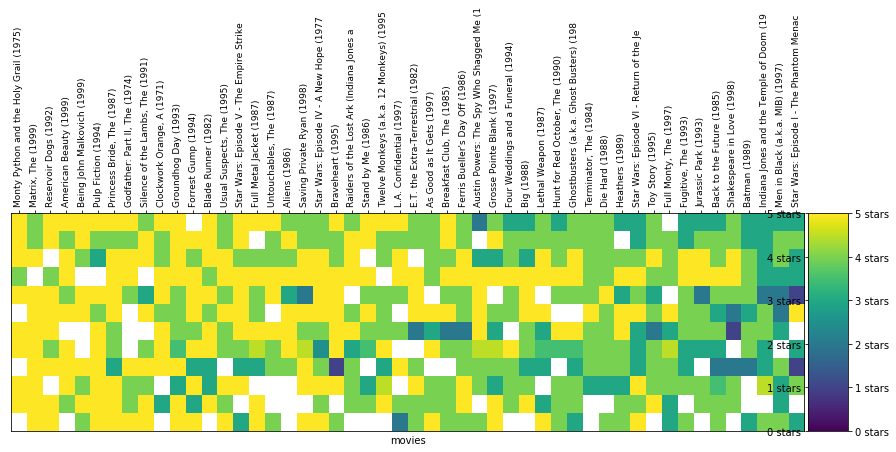

In [100]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # c = c+1
            # if c > 6:
            #    break
            
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

Neke stvari možemo primetiti sa ovih heat mapa:
- Što je više vertikalnih linija iste boje u klasteru, to će sličnije ocene biti u tom klasteru.
- Neki klasteri su proređeniji od drugih, što pokazuje da algoritam ima tendenciju da grupiše i ljude koji gledaju i ocenjuju manje filmova.
- Klasteri imaju tendenciju da imaju dominantnu boju: žućkastu, ako im se sviđaju njihovi ocenjeni filmovi, plavičastu, ako ne.
- Horizontalne linije iste boje odgovaraju korisnicima sa niskom raznolikošću u ocenama, koji vole da vole ili ne vole većinu filmova.

### AgglomerativeClustering

In [107]:
from sklearn.cluster import AgglomerativeClustering
clustering1 = AgglomerativeClustering(n_clusters=20).fit_predict(sparse_ratings.toarray())

cluster # 11
# of users in cluster: 11. # of users in plot: 11


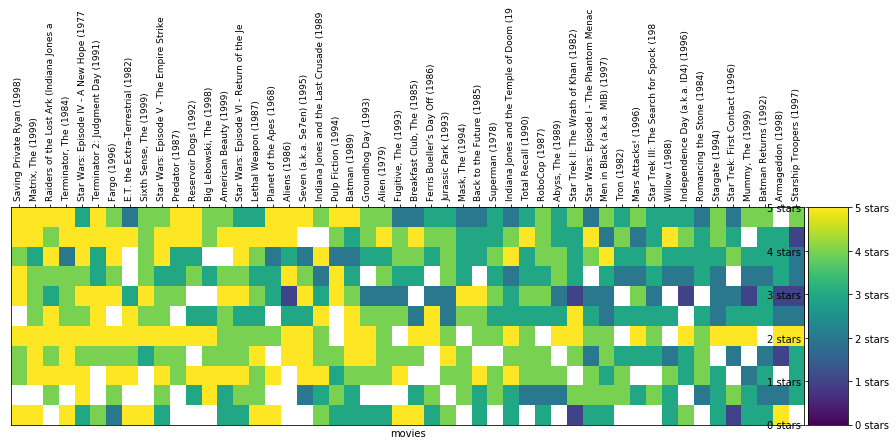

cluster # 17
# of users in cluster: 218. # of users in plot: 70


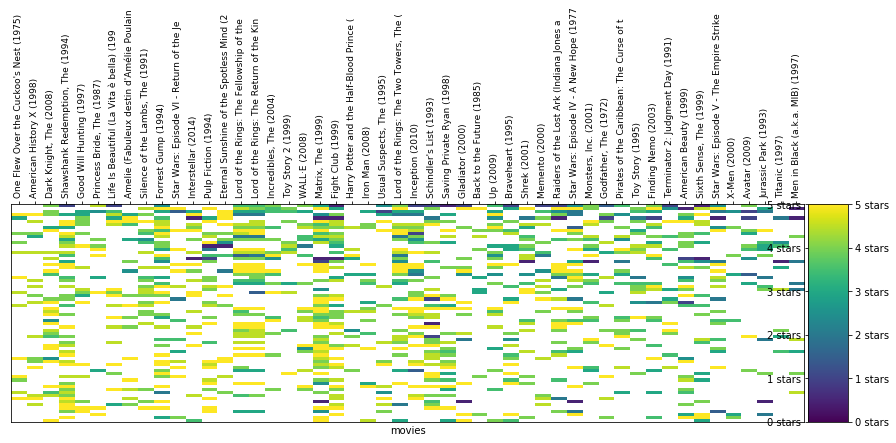

cluster # 0
# of users in cluster: 62. # of users in plot: 62


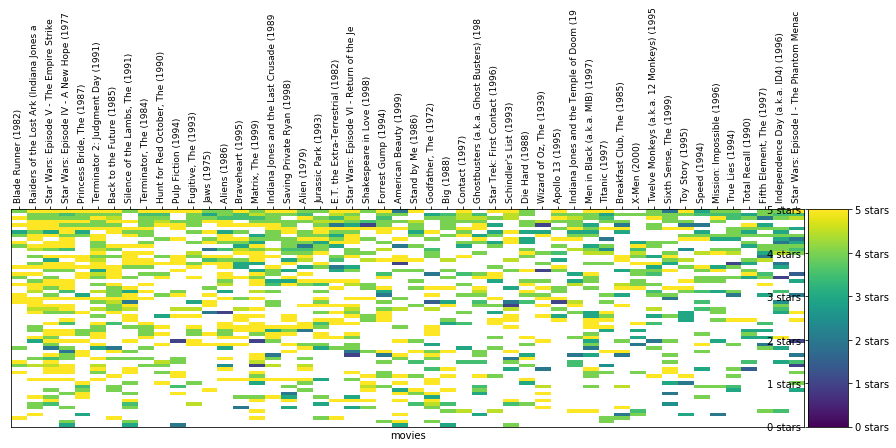

cluster # 1
# of users in cluster: 96. # of users in plot: 70


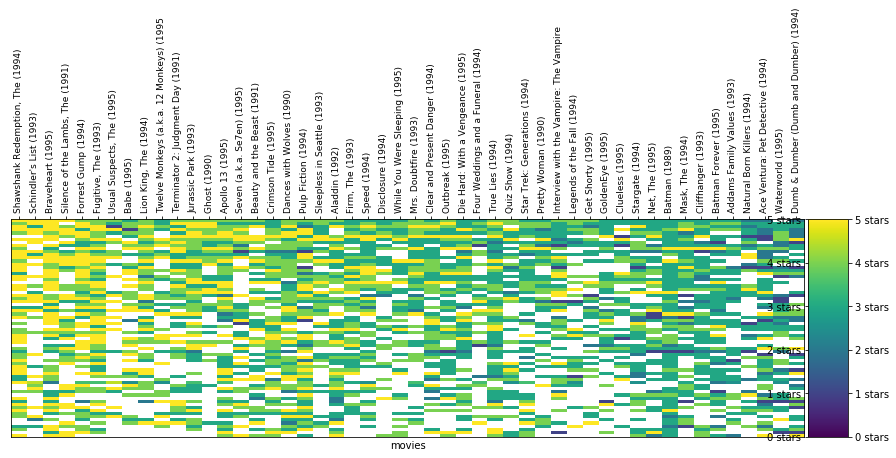

cluster # 7
# of users in cluster: 80. # of users in plot: 70


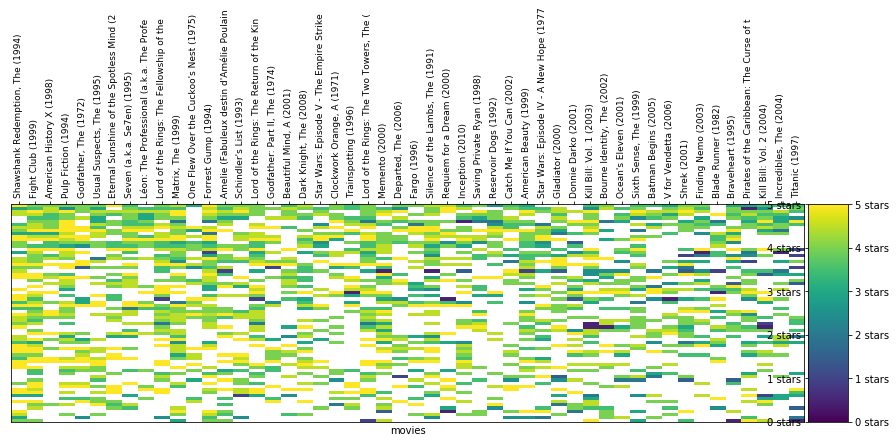

cluster # 16
# of users in cluster: 24. # of users in plot: 24


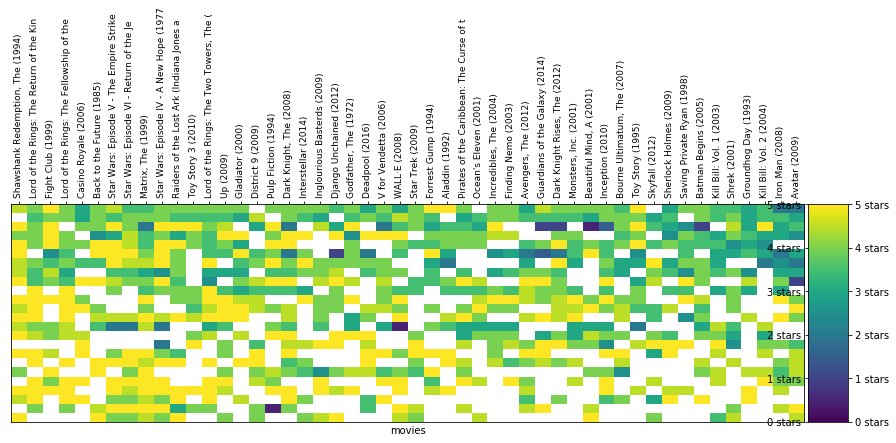

cluster # 9
# of users in cluster: 11. # of users in plot: 11


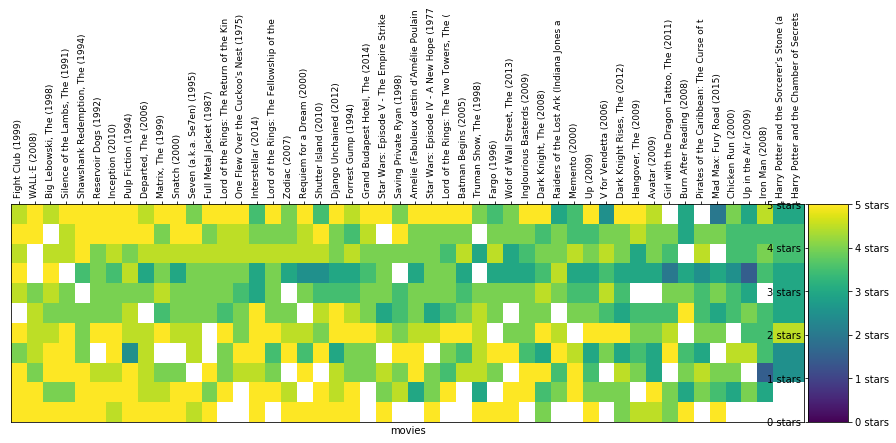

cluster # 6
# of users in cluster: 12. # of users in plot: 12


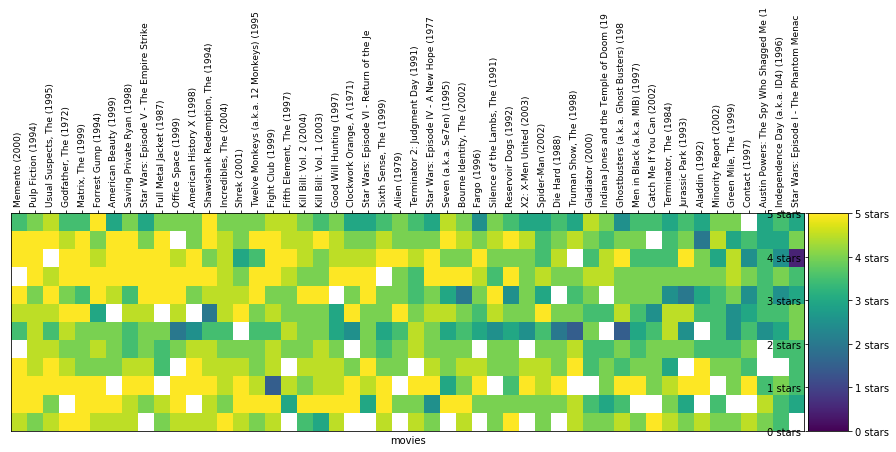

cluster # 13
# of users in cluster: 25. # of users in plot: 25


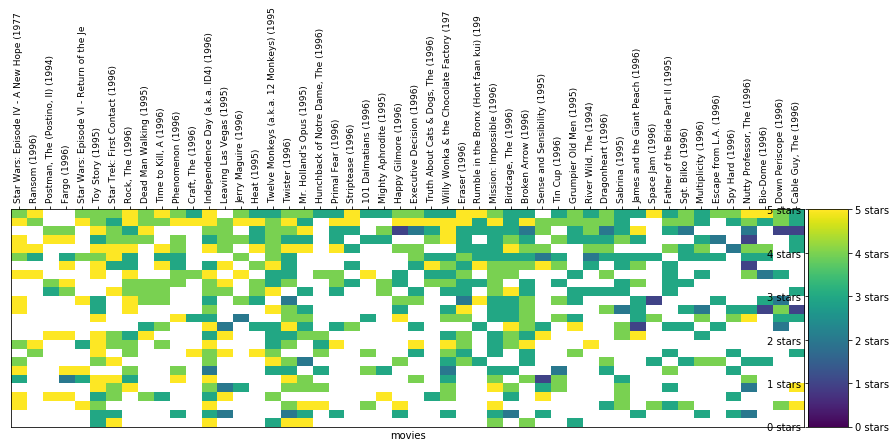

cluster # 15
# of users in cluster: 12. # of users in plot: 12


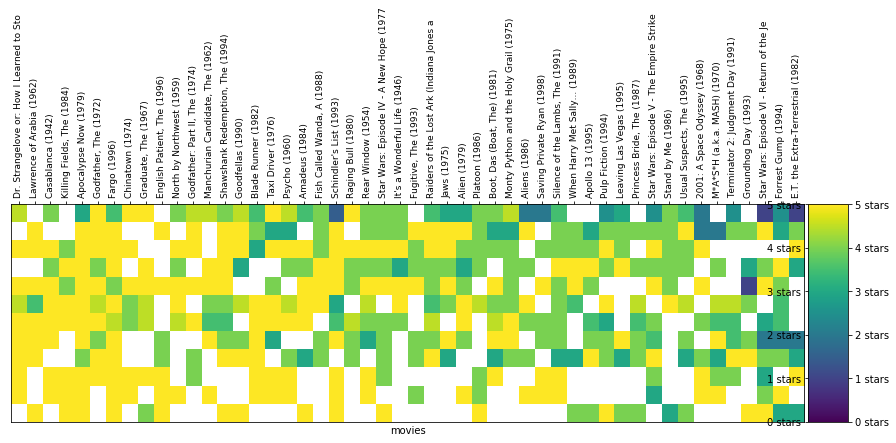

cluster # 4
# of users in cluster: 10. # of users in plot: 10


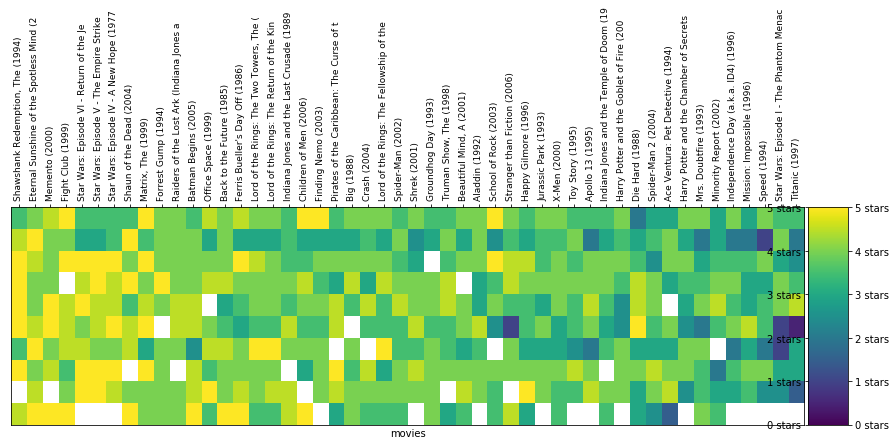

In [109]:
clustered1 = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':clustering1})], axis=1)
draw_movie_clusters(clustered1, max_users, max_movies)